In [18]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_modern = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
# There are 5 data sources needed for the analysis: legacy-desktop, legacy-mobile, modern-desktop,
    # modern-mobile-web, and modern-mobile-app
# Below, parameters are specified for each api call

# For legacy calls, see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
# legacy-desktop has data through July 2016 so the end parameter is the first day on the following month
params_legacy_desktop = {"project" : "en.wikipedia.org",
                         "access-site" : "desktop-site",
                         "granularity" : "monthly",
                         "start" : "2007120100",
                         "end" : "2016080100"
                        }

# legacy-mobile has the same date range as legacy-desktop
params_legacy_mobile = {"project" : "en.wikipedia.org",
                         "access-site" : "mobile-site",
                         "granularity" : "monthly",
                         "start" : "2007120100",
                         "end" : "2016080100"
                        }

# For modern calls, see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
# modern-desktop has data from July 2015 through the present date, but we'll use Sep 2019
params_modern_desktop = {"project" : "en.wikipedia.org",
                        "access" : "desktop",
                        "agent" : "user",
                        "granularity" : "monthly",
                        "start" : "2015070100",
                        "end" : '2019101000'
                        }

# modern-mobile-web has the same timeframe as modern-desktop
params_modern_mobile_web = {"project" : "en.wikipedia.org",
                            "access" : "mobile-web",
                            "agent" : "user",
                            "granularity" : "monthly",
                            "start" : "2015070100",
                            "end" : '2019101000'
                           }

# modern-mobile-app has the same timeframe as modern-desktop
params_modern_mobile_app = {"project" : "en.wikipedia.org",
                            "access" : "mobile-app",
                            "agent" : "user",
                            "granularity" : "monthly",
                            "start" : "2015070100",
                            "end" : '2019101000'
                           }

# Customize calls with my information
headers = {
            'User-Agent': 'https://github.com/WrightWillT',
            'From': 'wtwright@uw.edu'
}

In [4]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [5]:
# Make api calls and store json data
legacy_desktop_pagecounts = api_call(endpoint_legacy, params_legacy_desktop)
legacy_mobile_pagecounts = api_call(endpoint_legacy, params_legacy_mobile)
modern_desktop_pageviews = api_call(endpoint_modern, params_modern_desktop)
modern_mobile_web_pageviews = api_call(endpoint_modern, params_modern_mobile_web)
modern_mobile_app_pageviews = api_call(endpoint_modern, params_modern_mobile_app)

In [6]:
# save json data into the 'data_raw' folder
with open("../data_raw/pagecounts_desktop-site_200712-201608.json", "w") as write_file:
    json.dump(legacy_desktop_pagecounts, write_file)
with open("../data_raw/pagecounts_mobile-site_200712-201608.json", "w") as write_file:
    json.dump(legacy_mobile_pagecounts, write_file)
with open("../data_raw/pageviews_desktop_2015107-201910.json", "w") as write_file:
    json.dump(modern_desktop_pageviews, write_file)
with open("../data_raw/pageviews_mobile-web_2015107-201910.json", "w") as write_file:
    json.dump(modern_mobile_web_pageviews, write_file)
with open("../data_raw/pageviews_mobile_app_2015107-201910.json", "w") as write_file:
    json.dump(modern_mobile_app_pageviews, write_file)

In [7]:
# read data from hard disk (start here to avoid the api calls)
with open("../data_raw/pagecounts_desktop-site_200712-201608.json", "r") as read_file:
    legacy_desktop_pagecounts = json.load(read_file)
with open("../data_raw/pagecounts_mobile-site_200712-201608.json", "r") as read_file:
    legacy_mobile_pagecounts = json.load(read_file)
with open("../data_raw/pageviews_desktop_2015107-201910.json", "r") as read_file:
    modern_desktop_pageviews = json.load(read_file)
with open("../data_raw/pageviews_mobile-web_2015107-201910.json", "r") as read_file:
    modern_mobile_web_pageviews = json.load(read_file)
with open("../data_raw/pageviews_mobile_app_2015107-201910.json", "r") as read_file:
    modern_mobile_app_pageviews = json.load(read_file)

In [8]:
# convert each json object into dataframe
legacy_desktop_pagecounts_df = pd.DataFrame(legacy_desktop_pagecounts['items'])
legacy_mobile_pagecounts_df = pd.DataFrame(legacy_mobile_pagecounts['items'])
modern_desktop_pageviews_df = pd.DataFrame(modern_desktop_pageviews['items'])
modern_mobile_web_pageviews_df = pd.DataFrame(modern_mobile_web_pageviews['items'])
modern_mobile_app_pageviews_df = pd.DataFrame(modern_mobile_app_pageviews['items'])

In [9]:
# initialize dictionary for a unified dataframe with all months
date_data = {'timestamp': pd.date_range('2007-12-01','2019-09-01', 
                                 freq='MS').strftime("%Y%m%d%H").tolist()}

# convert to dataframe
wiki_traffic = pd.DataFrame(date_data)

# create columns for year and month from the timestamp
wiki_traffic['year'] = wiki_traffic['timestamp'].str[:4]
wiki_traffic['month'] = wiki_traffic['timestamp'].str[4:6]

In [10]:
# note: there's definitely a better way to do this, but python is a second language to me and this works
# join the other dataframes by timestamp to create a unified table, relabeling as needed
wiki_traffic = pd.merge(wiki_traffic,
                       legacy_desktop_pagecounts_df[['timestamp','count']],
                       left_on = "timestamp",
                       right_on = "timestamp",
                       how = "left")
wiki_traffic = wiki_traffic.rename(columns={'count': 'pagecount_desktop_views'})

wiki_traffic = pd.merge(wiki_traffic,
                       legacy_mobile_pagecounts_df[['timestamp','count']],
                       left_on = "timestamp",
                       right_on = "timestamp",
                       how = "left")
wiki_traffic = wiki_traffic.rename(columns={'count': 'pagecount_mobile_views'})

wiki_traffic = pd.merge(wiki_traffic,
                       modern_desktop_pageviews_df[['timestamp','views']],
                       left_on = "timestamp",
                       right_on = "timestamp",
                       how = "left")
wiki_traffic = wiki_traffic.rename(columns={'views': 'pageview_desktop_views'})

wiki_traffic = pd.merge(wiki_traffic,
                       modern_mobile_web_pageviews_df[['timestamp','views']],
                       left_on = "timestamp",
                       right_on = "timestamp",
                       how = "left")
wiki_traffic = wiki_traffic.rename(columns={'views': 'pageview_mobile_web_views'})

wiki_traffic = pd.merge(wiki_traffic,
                       modern_mobile_app_pageviews_df[['timestamp','views']],
                       left_on = "timestamp",
                       right_on = "timestamp",
                       how = "left")
wiki_traffic = wiki_traffic.rename(columns={'views': 'pageview_mobile_app_views'})

In [11]:
# convert all NaNs to 0s
wiki_traffic = wiki_traffic.fillna(0)

In [12]:
# create sum columns for pagecounts and pageviews as well as a sum for all mobile pageviews
wiki_traffic['pagecount_all_views'] = wiki_traffic['pagecount_desktop_views'] + wiki_traffic['pagecount_mobile_views']
wiki_traffic['pageview_mobile_views'] = wiki_traffic['pageview_mobile_web_views'] + wiki_traffic['pageview_mobile_app_views']
wiki_traffic['pageview_all_views'] = wiki_traffic['pageview_desktop_views'] + wiki_traffic['pageview_mobile_views']

In [13]:
# subset to columns needed for the analysis and rearrange to match expected format
wiki_traffic = wiki_traffic[['year',
                           'month',
                           'pagecount_all_views',
                           'pagecount_desktop_views',
                           'pagecount_mobile_views',
                           'pageview_all_views',
                           'pageview_desktop_views',
                           'pageview_mobile_views']]

In [15]:
# write to csv in the data_clean folder
wiki_traffic.to_csv("../data_clean/en-wikipedia_traffic_200712-201809.csv", index = False)

In [16]:
# read csv from hard disk (optional to start here if data is on hard disk)
wiki_traffic = pd.read_csv("../data_clean/en-wikipedia_traffic_200712-201809.csv")

In [62]:
plt.plot([1,2,3,4],[1,NaN,9,15])

NameError: name 'NaN' is not defined

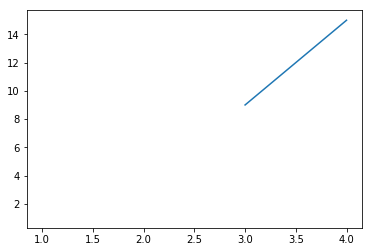

In [61]:
plt.plot([1,2,3,4],[1,None,9,15])

<Figure size 1080x720 with 0 Axes>

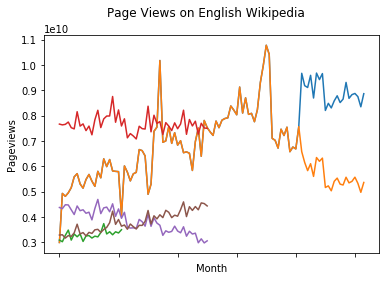

<Figure size 1080x720 with 0 Axes>

In [55]:
wiki_traffic[wiki_traffic['pagecount_all_views']>0].groupby(['year','month'])['pagecount_all_views'].sum().plot(kind='line')
wiki_traffic[wiki_traffic['pagecount_desktop_views']>0].groupby(['year','month'])['pagecount_desktop_views'].sum().plot(kind='line')
wiki_traffic[wiki_traffic['pagecount_mobile_views']>0].groupby(['year','month'])['pagecount_mobile_views'].sum().plot(kind='line')
wiki_traffic[wiki_traffic['pageview_all_views']>0].groupby(['year','month'])['pageview_all_views'].sum().plot(kind='line')
wiki_traffic[wiki_traffic['pageview_desktop_views']>0].groupby(['year','month'])['pageview_desktop_views'].sum().plot(kind='line')
wiki_traffic[wiki_traffic['pageview_mobile_views']>0].groupby(['year','month'])['pageview_mobile_views'].sum().plot(kind='line')
plt.ylabel('Pageviews')
plt.xlabel('Month')
plt.suptitle('Page Views on English Wikipedia')
plt.figure(figsize = (15,10))

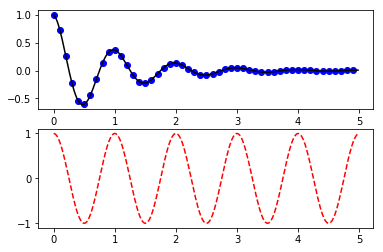

In [59]:
import numpy as np
def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)

plt.figure()
plt.subplot(211)
plt.plot(t1, f(t1), 'bo', t2, f(t2), 'k')

plt.subplot(212)
plt.plot(t2, np.cos(2*np.pi*t2), 'r--')
plt.show()